In [1]:
import os
import sys
import datetime
import math
import pandas as pd
import numpy as np
import quant_utils.data_moudle as dm
from quant_utils.constant import DB_CONN_JJTG_DATA, DB_CONN_JY
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号


In [2]:
cpi = """
SELECT
	date(DATE_ADD(InfoPublDate,INTERVAL 1 day)) as TRADE_DT,
	CPI - 100 as CPI
FROM
	`gildata`.`ed_consumerpriceindex` 
WHERE
	`ReportPeriod` = '11' 
	AND `ReportArea` = '1' 
ORDER BY TRADE_DT
"""
cpi = DB_CONN_JY.exec_query(cpi).dropna()

In [3]:
bond = """
SELECT
    TRADE_DT,
    B_ANAL_YIELD
from 
    cbond_curve_cnbd
WHERE
    1=1
	AND B_ANAL_CURVENUMBER = 1232 
	AND B_ANAL_CURVETERM = 10
ORDER BY TRADE_DT
"""
bond = DB_CONN_JJTG_DATA.exec_query(bond)

In [4]:
temperature = """
SELECT
	a.TRADE_DT,
	b.PE_TTM,
	b.DIVIDEND_YIELD 
FROM
	md_tradingdaynew a
	LEFT JOIN temperature_stock_index b ON a.TRADE_DT = b.TRADE_DT 
	AND b.TICKER_SYMBOL = '000985' 
WHERE
	1 = 1 
	AND a.SECU_MARKET = 83 
	AND a.TRADE_DT >= '20080101' 
	AND a.TRADE_DT < curdate()
"""
temperature = DB_CONN_JJTG_DATA.exec_query(temperature)
temperature = temperature.merge(bond, how='left')
temperature = temperature.merge(cpi, how='left')

In [5]:
temperature["CPI"] = temperature["CPI"].astype("float")

In [6]:
temperature = temperature.fillna(method="ffill").dropna()

C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_1144\3634628954.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temperature = temperature.fillna(method="ffill").dropna()


In [7]:
temperature.set_index("TRADE_DT", inplace=True)
temperature.index = pd.to_datetime(temperature.index)

In [8]:
temperature["real_instreset"] = temperature["B_ANAL_YIELD"] - temperature["CPI"]

In [9]:
temperature["real_erp"] = 100/temperature["PE_TTM"] - temperature["real_instreset"]
temperature["real_div"] = temperature["DIVIDEND_YIELD"] - temperature["real_instreset"]
temperature["erp"] = 100/temperature["PE_TTM"] - temperature["B_ANAL_YIELD"]

In [10]:
temperature['real_erp_rank'] = temperature["real_erp"].expanding().rank(pct=True, ascending=False)
temperature['erp_rank'] = temperature["erp"].expanding().rank(pct=True, ascending=False)

In [11]:
temperature["real_erp"]

TRADE_DT
2008-02-01    4.981087
2008-02-01    4.964183
2008-02-02    4.964183
2008-02-03    4.964183
2008-02-04    4.785900
                ...   
2024-05-31    4.021823
2024-06-01    4.021823
2024-06-02    4.021823
2024-06-03    4.045990
2024-06-04    4.021652
Name: real_erp, Length: 11322, dtype: float64

<Axes: xlabel='TRADE_DT'>

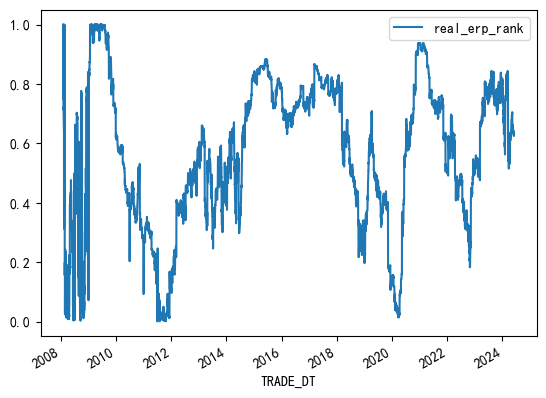

In [12]:
temperature[["real_erp_rank"]].plot()

In [13]:
temperature["CPI"]

TRADE_DT
2008-02-01    6.5
2008-02-01    6.5
2008-02-02    6.5
2008-02-03    6.5
2008-02-04    6.5
             ... 
2024-05-31    0.3
2024-06-01    0.3
2024-06-02    0.3
2024-06-03    0.3
2024-06-04    0.3
Name: CPI, Length: 11322, dtype: float64

In [14]:
df = pd.read_excel("C:/Users/Wilcoxon/Desktop/NDX.GI.xlsx", index_col=0)


In [15]:
from quant_utils.performance import Performance
result_list = []
for col in df.columns:
    result = Performance(df[col]).stats().T
    result["组合"] = col
    result_list.append(result)
result = pd.concat(result_list, axis=0)

In [16]:
result

,起始日期,结束日期,累计收益率,年化收益率,年化波动率,收益波动比,最大回撤,年化收益回撤比,最大回撤日,最大回撤修复,组合
0,1990-01-04 00:00:00,2024-05-31 00:00:00,81.491433,0.136751,0.266452,0.513228,0.828972,0.164964,20021007,4775,纳指
0,1990-01-04 00:00:00,2024-05-31 00:00:00,4.857535,0.052688,0.159398,0.330541,0.444897,0.118427,20151217,1681,黄金ETF
0,1990-01-04 00:00:00,2024-05-31 00:00:00,13.838221,0.081495,0.18101,0.450226,0.567754,0.14354,20090309,1480,SPX.GI
0,1990-01-04 00:00:00,2024-05-31 00:00:00,32.66183,0.107537,0.152861,0.703497,0.512967,0.209637,20021009,1274,纳指+黄金
0,1990-01-04 00:00:00,2024-05-31 00:00:00,11.056502,0.074994,0.118926,0.630588,0.33166,0.226116,20081120,356,标普+黄金


In [42]:
query_sql = f"""
SELECT
	END_DATE,
	TICKER_SYMBOL,
	ADJ_NAV 
FROM
	fund_adj_nav 
WHERE
	1 = 1 
	AND TICKER_SYMBOL IN (
		'513500',
		'518880',
        '159941',
        '512890',
        '515080',
        '159985',
        '159981',
        '512400',
        '511220'
	)
    # AND END_DATE >= '20151231'
"""
df = DB_CONN_JJTG_DATA.exec_query(query_sql)
df = df.pivot_table(index="END_DATE", columns="TICKER_SYMBOL", values="ADJ_NAV").dropna().pct_change()
df = df.fillna(0)
# df["黄金+纳指+红利"] = df["159941"]/3+df["518880"]/3+df["510880"]/3
# df["黄金+纳指+红利+创业板"] = df["159941"]/4+df["518880"]/4+df["510880"]/4+df["159915"]/4
df["黄金+标普"] = df["513500"]/2+df["518880"]/2
df["黄金+纳指"] = df["159941"]/2+df["518880"]/2
df["黄金+纳指+标普"] = df["159941"]/2/2 + df["513500"]/2/2 +df["518880"]/2
df["黄金+纳指+红利低波"] = df["159941"]/3+df["518880"]/3+df["512890"]/3
df["黄金+纳指+中证红利"] = df["159941"]/3+df["518880"]/3+df["515080"]/3
df["黄金+纳指+红利低波+豆粕"] = (df["159941"]+df["518880"]+df["512890"]+df['159985'])/4
df["黄金+纳指+红利低波+豆粕+能源化工"] = (df["159941"]+df["518880"]+df["512890"]+df['159985']+df["159981"])/5
df["黄金+纳指+红利低波+豆粕+能源化工+有色"] = (df["159941"]+df["518880"]+df["512890"]+df['159985']+df["159981"]+df["512400"])/6
df["黄金+纳指+红利低波+豆粕+能源化工+有色+城投"] = (df["159941"]+df["518880"]+df["512890"]+df['159985']+df["159981"]+df["512400"]+df["511220"])/7
df1 = (df + 1).cumprod()

In [43]:
df1

TICKER_SYMBOL,159941,159981,159985,511220,512400,512890,513500,515080,518880,黄金+标普,黄金+纳指,黄金+纳指+标普,黄金+纳指+红利低波,黄金+纳指+中证红利,黄金+纳指+红利低波+豆粕,黄金+纳指+红利低波+豆粕+能源化工,黄金+纳指+红利低波+豆粕+能源化工+有色,黄金+纳指+红利低波+豆粕+能源化工+有色+城投
END_DATE,,,,,,,,,,,,,,,,,,
2019-12-13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2019-12-20,1.018983,1.000100,0.998977,1.000539,1.022413,1.010874,1.014322,1.008912,1.009431,1.011877,1.014207,1.013042,1.013096,1.012442,1.009567,1.007673,1.010130,1.008760
2019-12-27,1.028080,1.003500,0.997648,1.001972,1.101474,1.012998,1.018023,1.009687,1.026189,1.022122,1.027153,1.024636,1.022427,1.021317,1.016204,1.013658,1.028148,1.024389
2019-12-31,1.021980,1.003900,1.010942,1.002494,1.116058,1.032623,1.013505,1.028480,1.027349,1.020431,1.024686,1.022558,1.027392,1.026018,1.023291,1.019394,1.035265,1.030544
2020-01-03,1.028080,1.005599,1.011351,1.003262,1.150138,1.042137,1.013793,1.041945,1.046548,1.030111,1.037319,1.033711,1.038992,1.038928,1.032059,1.026728,1.046740,1.040448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28,2.145869,1.681632,2.373351,1.188864,1.651213,1.851669,1.711924,1.853520,1.628532,1.731521,1.959920,1.844712,1.967788,1.965914,2.096962,2.032781,2.015042,1.874850
2024-05-29,2.131356,1.680132,2.316495,1.189364,1.692508,1.852859,1.699524,1.857611,1.637506,1.730021,1.958692,1.843335,1.967388,1.966540,2.084083,2.022430,2.014891,1.874842
2024-05-30,2.108219,1.701030,2.305348,1.189584,1.641848,1.839266,1.689431,1.842650,1.625572,1.718580,1.940923,1.828879,1.950678,1.949367,2.068301,2.015209,1.998844,1.862094


In [44]:
result_list = []
for i in df1.columns:
    result = Performance(df1[i]).stats().T
    result["组合"] = i
    result_list.append(result)
result = pd.concat(result_list, axis=0)

In [45]:
result.sort_values(by="收益波动比", ascending=False)

,起始日期,结束日期,累计收益率,年化收益率,年化波动率,收益波动比,最大回撤,年化收益回撤比,最大回撤日,最大回撤修复,组合
0,2019-12-13,2024-06-03,0.190153,0.039801,0.007051,5.644677,0.022322,1.78304,20221215,97,511220
0,2019-12-13,2024-06-03,1.000931,0.168252,0.096413,1.745122,0.110226,1.526433,20200319,78,黄金+纳指+红利低波+豆粕+能源化工
0,2019-12-13,2024-06-03,1.059911,0.175886,0.101812,1.727561,0.101204,1.737945,20200319,50,黄金+纳指+红利低波+豆粕
0,2019-12-13,2024-06-03,0.846166,0.147356,0.096569,1.525912,0.109629,1.344133,20200323,100,黄金+纳指+红利低波+豆粕+能源化工+有色+城投
0,2019-12-13,2024-06-03,0.978741,0.165335,0.112685,1.467239,0.127389,1.29788,20200323,100,黄金+纳指+红利低波+豆粕+能源化工+有色
0,2019-12-13,2024-06-03,0.943792,0.160689,0.120397,1.334659,0.143686,1.118328,20200323,46,黄金+纳指+红利低波
0,2019-12-13,2024-06-03,0.944892,0.160836,0.120877,1.330572,0.144896,1.11001,20200323,56,黄金+纳指+中证红利
0,2019-12-13,2024-06-03,1.292361,0.204415,0.174074,1.174299,0.182527,1.119914,20240130,99999,159985
0,2019-12-13,2024-06-03,0.939349,0.160093,0.149262,1.072564,0.163319,0.980247,20200323,45,黄金+纳指
0,2019-12-13,2024-06-03,0.830042,0.145102,0.137965,1.051732,0.183424,0.791074,20200323,56,黄金+纳指+标普


<Axes: xlabel='END_DATE'>

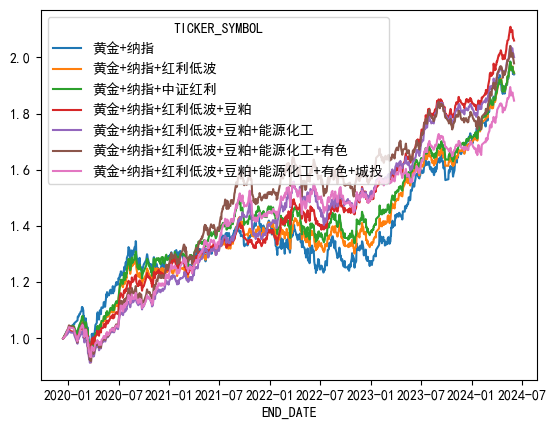

In [47]:
df1[
    [
    "黄金+纳指", 
    "黄金+纳指+红利低波", 
    "黄金+纳指+中证红利", 
    "黄金+纳指+红利低波+豆粕", 
    "黄金+纳指+红利低波+豆粕+能源化工",
    "黄金+纳指+红利低波+豆粕+能源化工+有色",
    "黄金+纳指+红利低波+豆粕+能源化工+有色+城投",
    ]
].plot()